# Redes neuronales para pronosticar el número de pasajeros aéreos

Vamos a utilizar modelos de redes neuronales para realizar tareas de pronóstico.

Los datos que vamos a analizar son los correspondientes al número de pasajeros aéreos mensuales. Van desde enero de 1949 hasta diciembre de 1960.

In [1]:
import numpy as np
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Entendimiento de los datos

Cargamos los datos para entenderlos

In [3]:
df = pd.read_csv('08-03-AirPassengers.csv', sep=',', na_values=".")
print(df.shape)
df.head(5)

(144, 2)


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Vamos a modificar el nombre de las variables ("#Passengers" no nos permite acceder fácilmente a esa columna del dataframe).

In [4]:
df.columns = ['Mes', 'Pasajeros']

In [5]:
df.shape[0]

144

Tenemos 144 datos, correspondientes a los números de pasajeros mensuales en los últimos 12 años. Visualicemos los datos para buscar patrones.

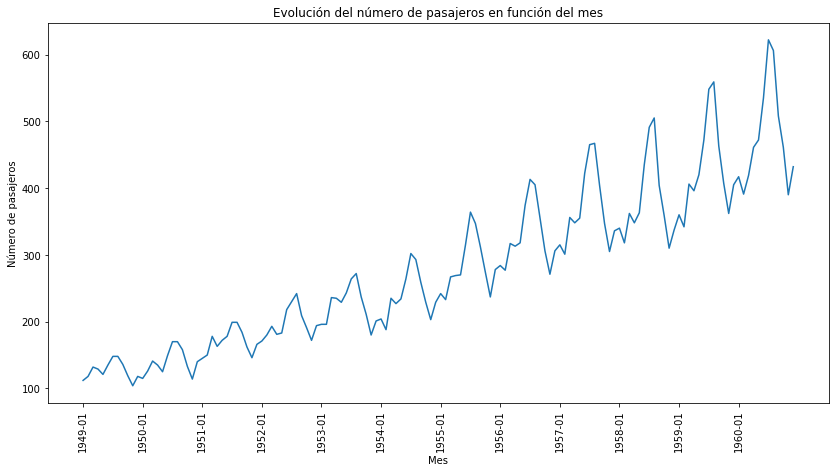

In [6]:
plt.figure(figsize=(14,7))
ax = plt.gca() # get current axis
plt.plot(df.Mes, df.Pasajeros)
plt.xlabel('Mes')
plt.ylabel('Número de pasajeros')
plt.title('Evolución del número de pasajeros en función del mes')
plt.xticks(np.arange(0,144,12), rotation=90)
plt.show()

Nos salta a la vista la estacionalidad de los datos y la tendencia creciente.

## Preparación de los datos

Tenemos unos datos representados por una serie de tiempo univariada.

Al utilizar un modelo de redes neuronales con capas densas feed-forward para realizar pronósticos sobre series temporales univariadas, necesitamos configurar sus capas de entrada y de salida con respecto a lo que se espera del modelo. Hay diferentes aproximaciones posibles a considerar, con respecto al número de modelos que se van a desarrollar, a si se quiere un modelo con varios pronósticos al mismo tiempo o no, y a si se quiere tener en cuenta recursividamente o no las predicciones de modelos anteriores.

El número de neuronas de la capa de entrada debe establecerse con respecto a la ventana temporal de periodos contiguos que nos permitirán realizar el pronóstico. 

En el enfoque que vamos a adoptar, los inputs de la red neuronal van a representar los valores de la variable a pronósticar un cierto número de periodos atrás en el tiempo. 
Por ejemplo, con 4 neuronas, podemos tener en cuenta la información de 4 periodos continuos, uno por cada neurona.
Por otra parte, vamos a pronosticar un solo periodo en el futuro, por lo que solo necesitaremos una neurona de salida.

Esto tiene como implicación que tenemos que transformar los datos univariados en particiones con tantos periodos contiguos como neuronas de entrada.

La siguiente función (tomada de https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/) nos permite obtener particionamientos de periodos contiguos en la serie de datos.

In [7]:
def split_sequence(sequence, n_steps):
    X, y = list(), list() # se crean listas vacías donde agregaremos los valores de las variables predictivas (X)
                          # y de la variable objetivo (y)
        
    for i in range(len(sequence)): # recorremos la serie de tiempo posición por posición
        # Se obtiene el índice del final de la secuencia de datos con los valores de las variables predictivas (X)
        end_ix = i + n_steps 
        # condición de salida: no alcanzamos a obtener los datos de "X" y "y"
        if end_ix > len(sequence)-1: 
            break
        # creamos los datos de la instancia del periodo actual, los periodos del "X" y el periodo a predicir "y"
        # y los agregamos a las listas correspondientes
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y) # retornamos una tupla con los datos de la instancia

Por ejemplo las primeras 12 instancias de nuestro dataset, con los 6 datos precedentes para predecir el 7o serían (vamos a analizar las fechas para entender temporalmente lo que se obtiene):

In [8]:
X, y = split_sequence(df.iloc[0:12, 0], 6)
for i in range(len(X)):
    print(X[i], y[i])

['1949-01' '1949-02' '1949-03' '1949-04' '1949-05' '1949-06'] 1949-07
['1949-02' '1949-03' '1949-04' '1949-05' '1949-06' '1949-07'] 1949-08
['1949-03' '1949-04' '1949-05' '1949-06' '1949-07' '1949-08'] 1949-09
['1949-04' '1949-05' '1949-06' '1949-07' '1949-08' '1949-09'] 1949-10
['1949-05' '1949-06' '1949-07' '1949-08' '1949-09' '1949-10'] 1949-11
['1949-06' '1949-07' '1949-08' '1949-09' '1949-10' '1949-11'] 1949-12


Creamos ahora nuestro dataset completo, sobre los datos del número de pasajeros. El numero de pasos a considerar lo vamos a establecer en 12, ya que se trata de datos anuales, y podemos encontrar evidencias visuales de ciclos de 12 datos.
X va a contener los valores de la varible número de pasajeros de los 12 meses anteriores al valor contenido por y.
Adicionalmente, necesitamos tener saber el mes correspondiente al y predicho, que lo dejaremos en mes.

In [9]:
pasos = 12

In [10]:
X, y = split_sequence(df.iloc[:, 1], pasos)

In [11]:
meses_pronosticados = df.iloc[pasos:,0]
meses_pronosticados

12     1950-01
13     1950-02
14     1950-03
15     1950-04
16     1950-05
        ...   
139    1960-08
140    1960-09
141    1960-10
142    1960-11
143    1960-12
Name: Mes, Length: 132, dtype: object

## Modelamiento y evaluación

Vamos a llevar a cabo diferentes evaluaciones del modelo.

### Estimación de múltiples pasos, ventana fija

Ahora que ya tenemos los datos en la presentación correcta, vamos a separarlos en dos particiones, una para entrenamiento y otra para evaluación.

Al tratarse de datos temporales, no tiene sentido particionar los datos de manera aleatoria, pues el orden de las secuencias de datos es importante. Vamos entonces a considerar una porción de los datos inicial, llamada *in-sample* para entrenar los modelos, seguida de la porción *out-of-sample*, que se utilizará para evaluar la capacidad predictiva.

Tenemos 132 instancias, vamos a dejar los últimos 12 meses para evaluación, entrenando sobre los primeros 10 años (120 meses).

In [12]:
periodos_train =120
periodos_test = X.shape[0]-periodos_train

In [13]:
X_train = X[:periodos_train]
X_test = X[periodos_train:]
y_train = y[:periodos_train]
y_test = y[periodos_train:]
meses_train = meses_pronosticados[:periodos_train]
meses_test = meses_pronosticados[periodos_train:]
print("X_train: {}, y_train: {}\nX_test: {}, y_test: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train: (120, 12), y_train: (120,)
X_test: (12, 12), y_test: (12,)


In [14]:
meses_train

12     1950-01
13     1950-02
14     1950-03
15     1950-04
16     1950-05
        ...   
127    1959-08
128    1959-09
129    1959-10
130    1959-11
131    1959-12
Name: Mes, Length: 120, dtype: object

Entrenamos el modelo con una ventana de datos fija de 120 meses.

In [15]:
np.random.seed(1234)
mlp = MLPRegressor(hidden_layer_sizes=(10,10,10), max_iter=500)
mlp.fit(X_train,y_train)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 10, 10), learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [16]:
y_pred = mlp.predict(X_test)
print("RMSE:", sqrt(mean_squared_error(y_test, y_pred)), ", MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

RMSE: 16.64691118641908 , MAE: 14.662016168909128 , R2: 0.9499736363083783 



Visualicemos los datos

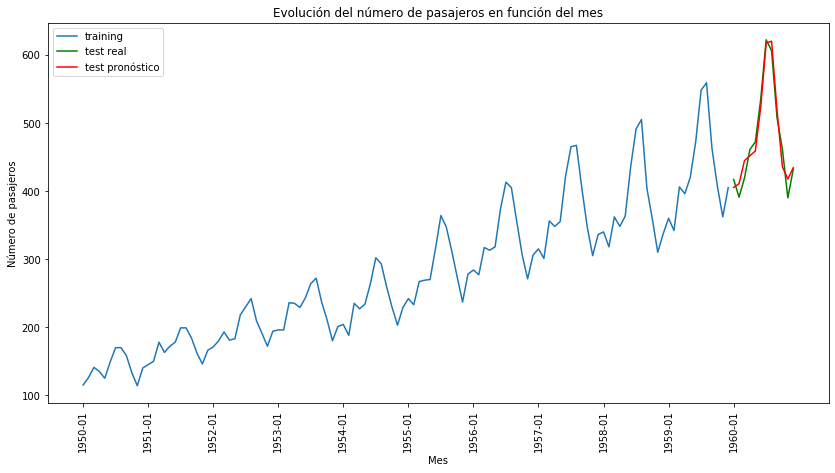

In [17]:
plt.figure(figsize=(14,7))
ax = plt.gca() # get current axis
plt.plot(meses_train, y_train, label="training")
plt.plot(meses_test, y_test, c="g", label="test real")
plt.plot(meses_test, y_pred, c="r", label="test pronóstico")
plt.xlabel('Mes')
plt.ylabel('Número de pasajeros')
plt.title('Evolución del número de pasajeros en función del mes')
plt.legend()
plt.xticks(np.arange(0,132,12), rotation=90)
plt.show()

### Estimación de un paso a la vez, ventana móvil

Para este protocolo, vamos a estimar un modelo cada vez con los últimos 120 periodos previos al dato que se desea pronosticar.

In [18]:
y_preds = np.zeros(periodos_test)
for i in np.arange(0,periodos_test):
    X_train = X[i:i+periodos_train]
    y_train = y[i:i+periodos_train]
    X_test = X[i+periodos_train]
    y_test = y[i+periodos_train]
    np.random.seed(1234)
    mlp = MLPRegressor(hidden_layer_sizes=(10,10,10), max_iter=500)
    mlp.fit(X_train,y_train)
    y_pred = mlp.predict(X_test.reshape(1,pasos))
    y_preds[i]=y_pred
    print("ytest: ", y_test, ", y_pred: ", y_pred)


ytest:  417 , y_pred:  [405.3286437]
ytest:  391 , y_pred:  [411.08963182]
ytest:  419 , y_pred:  [443.79729489]
ytest:  461 , y_pred:  [449.4952866]
ytest:  472 , y_pred:  [459.05571269]
ytest:  535 , y_pred:  [524.65057804]
ytest:  622 , y_pred:  [609.838837]
ytest:  606 , y_pred:  [621.70946816]
ytest:  508 , y_pred:  [519.42478862]
ytest:  461 , y_pred:  [437.28248419]
ytest:  390 , y_pred:  [419.17871129]
ytest:  432 , y_pred:  [432.42455762]


In [19]:
y_test = y[periodos_train:]

In [20]:
print("RMSE:", sqrt(mean_squared_error(y_test, y_preds)), ", MAE:", mean_absolute_error(y_test, y_preds), 
      ", R2:", r2_score(y_test, y_preds), "\n")

    

RMSE: 17.08080868997911 , MAE: 15.331075847962955 , R2: 0.9473318009731574 



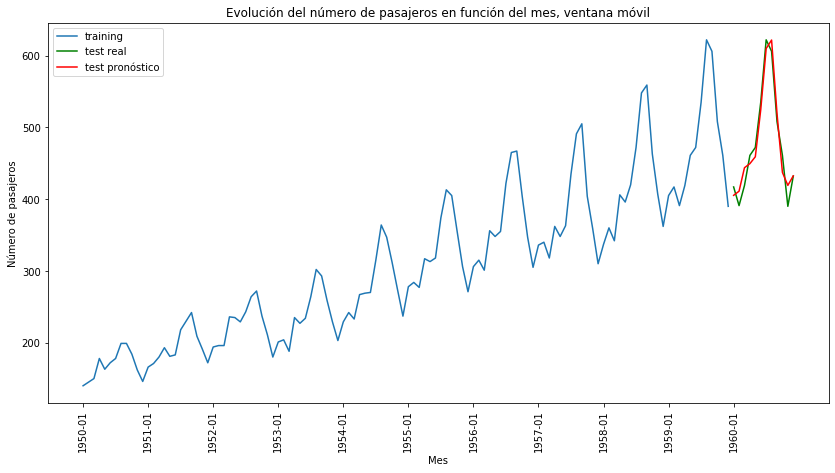

In [21]:
plt.figure(figsize=(14,7))
ax = plt.gca() # get current axis
plt.plot(meses_train, y_train, label="training")
plt.plot(meses_test, y_test, c="g", label="test real")
plt.plot(meses_test, y_preds, c="r", label="test pronóstico")
plt.xlabel('Mes')
plt.ylabel('Número de pasajeros')
plt.title('Evolución del número de pasajeros en función del mes, ventana móvil')
plt.legend()
plt.xticks(np.arange(0,132,12), rotation=90)
plt.show()

### Estimación de un paso a la vez, ventana recursiva

Para este protocolo, vamos a estimar un modelo cada vez con los últimos 120 periodos previos al dato que se desea pronosticar.

In [22]:
y_preds = np.zeros(periodos_test)
for i in np.arange(0,periodos_test):
    X_train = X[:i+periodos_train]
    y_train = y[:i+periodos_train]
    X_test = X[i+periodos_train]
    y_test = y[i+periodos_train]
    np.random.seed(1234)
    mlp = MLPRegressor(hidden_layer_sizes=(10,10,10), max_iter=500)
    mlp.fit(X_train,y_train)
    y_pred = mlp.predict(X_test.reshape(1,pasos))
    y_preds[i]=y_pred
    print("ytest: ", y_test, ", y_pred: ", y_pred)


ytest:  417 , y_pred:  [405.3286437]
ytest:  391 , y_pred:  [410.72825332]
ytest:  419 , y_pred:  [443.92471243]
ytest:  461 , y_pred:  [449.68272033]
ytest:  472 , y_pred:  [459.21976819]
ytest:  535 , y_pred:  [527.72225287]
ytest:  622 , y_pred:  [610.77687959]
ytest:  606 , y_pred:  [620.35585942]
ytest:  508 , y_pred:  [517.89465732]
ytest:  461 , y_pred:  [436.53374476]
ytest:  390 , y_pred:  [420.00508396]
ytest:  432 , y_pred:  [432.00173657]


In [23]:
y_test = y[periodos_train:]

In [24]:
print("RMSE:", sqrt(mean_squared_error(y_test, y_preds)), ", MAE:", mean_absolute_error(y_test, y_preds), 
      ", R2:", r2_score(y_test, y_preds), "\n")    

RMSE: 16.881702769795414 , MAE: 14.803857797722367 , R2: 0.9485525196309423 



In [25]:
y_train = y[:periodos_train]
y_test = y[periodos_train:]
meses_train = meses_pronosticados[:periodos_train]
meses_test = meses_pronosticados[periodos_train:]

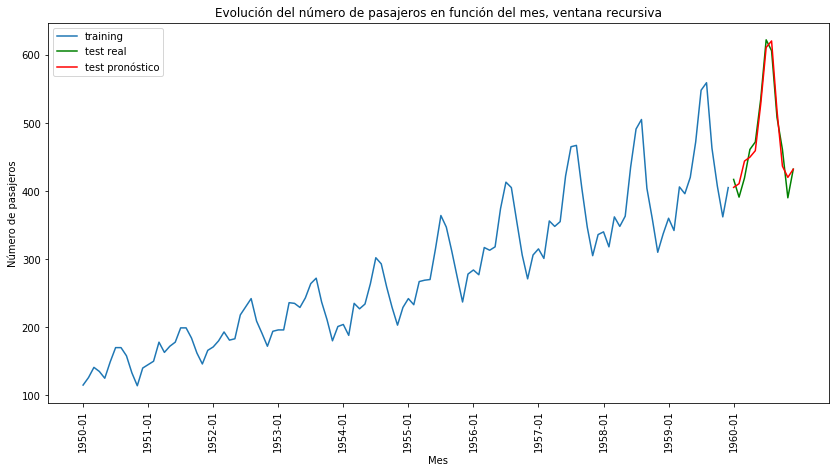

In [26]:
plt.figure(figsize=(14,7))
ax = plt.gca() # get current axis
plt.plot(meses_train, y_train, label="training")
plt.plot(meses_test, y_test, c="g", label="test real")
plt.plot(meses_test, y_preds, c="r", label="test pronóstico")
plt.xlabel('Mes')
plt.ylabel('Número de pasajeros')
plt.title('Evolución del número de pasajeros en función del mes, ventana recursiva')
plt.legend()
plt.xticks(np.arange(0,132,12), rotation=90)
plt.show()